## Saheed Adisa Ganiyu

**Exercise 10.1.** Consider example of the Ising model with zero singleton term, $h=0$, and uniform pair-wise term, $J \beta=-1$, i.e. $J_{i j} \beta=-1, \forall\{i, j\} \in \mathcal{E}$, over $n \times n$ grid-graph with the nearest-neighbor interaction. Construct (write down pseudo-algorithm and then code) the decimation algorithm (6).

Compare the performance of the direct sampling for $n=2,3,4,5$ - that is find out how the time required to generate the next i.i.d. sample depends on $n$ - and explain.

**Solution:** \
**Algorithm:** Decimation Algorithm for 2D Ising Model.\
**Input:** size of the lattice $n$.
1. initialize lattice $x$ with $0$, and set $x^d = \emptyset$\
2. choose a spin $x_{i,j}$ uniformly at random\
3. compute acceptance probability $prob$.\
4. generate a uniform random number $p$\
5. if $r <p$ **do** flip $x_{i,j}$\
6. append the $x$ to $x^d$\
7. repeat steps 2-6 until states of the lattice is reached.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# function to calculate energy of the lattice
global beta
global H
global J
def E_tot(lat):
    S = 0
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]-1):
            S += -1/2 * (lat[i,j]*J*lat[i,j+1])
        for j in range(lat.shape[1]):
            S += H * lat[i,j]
    for j in range(lat.shape[1]):
        for i in range(lat.shape[0]-1):
            S += -1/2 * (lat[i,j]*J*lat[i+1,j])
    return S

# parameters
J,H,beta = 1, 0, -1

def prob(lat):  # non normalized probability
    return np.exp(-beta*E_tot(lat))

def ising_decimation(n):
    lats = []
    # initialize with 0s so only states already assigned will contribute
    lat = np.zeros((n,n))
    for i in np.random.permutation(n):
        for j in np.random.permutation(n):
            lat[i,j] = 1
            pp1 = prob(lat)
            lat[i,j] = -1
            pm1 = prob(lat)
            p = np.random.uniform()
            if p < pp1/(pp1+pm1):
                lat[i,j] = 1
    lats = lats + [lat.copy()]
    return lats

In [10]:
# Direct Sampling using Metropolis algorithm
def ising_metropolis(n, beta):
    lattice = 2*np.random.randint(2, size=(n,n))-1
    J = 1.0
    for i in range(n):
        for j in range(n):
                a = np.random.randint(0, n)
                b = np.random.randint(0, n)
                s =  lattice[a, b]
                nb = lattice[(a+1)%n,b] + lattice[a,(b+1)%n] + lattice[(a-1)%n,b] + lattice[a,(b-1)%n]
                dE = 2*J*s*nb
                if dE < 0:
                    s *= -1
                elif np.random.uniform() < np.exp(-dE*beta):
                    s *= -1
                lattice[a, b] = s
    return lattice

In [11]:
import time

for n in range(2, 6):
    print(f"n = {n}")
    
    # Decimation algorithm
    start_time = time.time()
    for i in range(1000):
        ising_decimation(n)
    print(f"Decimation time: {time.time() - start_time}")
    
    # Direct sampling
    start_time = time.time()
    for i in range(1000):
        ising_metropolis(n, beta=-1)
    print(f"Direct Sampling time: {time.time() - start_time}\n")


n = 2
Decimation time: 0.15550756454467773
Direct Sampling time: 0.07449126243591309

n = 3
Decimation time: 0.3532288074493408
Direct Sampling time: 0.13236093521118164

n = 4
Decimation time: 0.8690123558044434
Direct Sampling time: 0.20649957656860352

n = 5
Decimation time: 2.0839109420776367
Direct Sampling time: 0.31449222564697266



**Remark:** From the above result, it is surprized that Direct sampling is faster than Decimation algorithm. I guess that it may be due to my own implementation, unfortunately, there no more time for me to figure it out.

**Problem 10.5:** Find the Chow-Liu optimal spanning tree approximation for the joint probability distribution of four random binary variables with statistical information presented in the Table 10.1. [Hint: Estimate the empirical (i.e. based on the data), pair-wise mutual information and then utilize the Chow-Liu-Kruskal algorithm (see description above in the lecture notes) to reconstruct the optimal tree.]

**Solution:** As it is given in the algorithm, we need to calculate Mutual Information $I(X_i,X_j)$, which is defined as 
$$
I\left(X_i, X_j\right):=\sum_{x_i, x_j} P\left(x_i, x_j\right) \log \frac{P\left(x_i, x_j\right)}{P\left(x_i\right) P\left(x_j\right)}.
$$
Therefore, we need to calculate $P\left(x_i\right)$, and $P\left(x_i, x_j\right)$. From the given table, we can obtain the marginal probability of $X_i$ as follow, for instance, $P(X_1 = m)$, and $P(X_1 = k, X_2 = m)$:

$$ 
P(X_1 = k) = \sum P(X_1 = k, X_2, X_3, X_4).
$$
Similarly, we have
$$
P(X_1 = k, X_2 = m) = \sum P(X_1 = k, X_2 = m, X_3, X_4).
$$
Therefore, we have

In [12]:
p_x1 = np.array([0.45,0.55])
p_x2 = np.array([0.45,0.55])
p_x3 = np.array([0.45,0.55])
p_x4 = np.array([0.5,0.5])
p_x1x2 = np.array([[0.3,0.15],[0.15,0.4]])
p_x1x3 = np.array([[0.2,0.25],[0.25,0.3]])
p_x1x4 = np.array([[0.25,0.25],[0.2,0.3]])
p_x2x3 = np.array([[0.35,0.1],[0.1,0.45]])
p_x2x4 = np.array([[0.2,0.3],[0.25,0.25]])
p_x3x4 = np.array([[0.2,0.3],[0.25,0.25]])

In [13]:
# definition of Mutual Information 
def mutual_info(p_xixj,p_xi,p_xj):
    event = [0,1]
    I_xixj = 0
    for i in event:
        for j in event:
            I_xixj += p_xixj[i,j]*np.log(p_xixj[i,j]/(p_xi[i]*p_xj[j]))
    return I_xixj

In [19]:
# Calculating the Mutual Information
print('I_x1x2 = {}'.format(mutual_info(p_x1x2,p_x1,p_x2)))
print('I_x1x3 = {}'.format(mutual_info(p_x1x3,p_x1,p_x3)))
print('I_x1x4 = {}'.format(mutual_info(p_x1x4,p_x1,p_x4)))
print('I_x2x3 = {}'.format(mutual_info(p_x2x3,p_x2,p_x3)))
print('I_x2x4 = {}'.format(mutual_info(p_x2x4,p_x2,p_x4)))
print('I_x3x4 = {}'.format(mutual_info(p_x3x4,p_x3,p_x4)))

I_x1x2 = 0.07943349791396961
I_x1x3 = 5.1023082630614024e-05
I_x1x4 = 0.015092924702095164
I_x2x3 = 0.18899440195583322
I_x2x4 = 0.015092924702095136
I_x3x4 = 0.015092924702095136


**Remark:** from the Chow-Liu-Kruskal algorithm, we will have those folowing edges connected $X2X3, X2X1, X1X4$ orderly.

**Proble 10.6.** Consider the following two-layer $(L=2)$ NN-map, $v \rightarrow w$ where $v, w \in \mathbb{R}$, built from three ReLU neurons :
$$
v_{1 i}=\operatorname{ReLU}\left(a_i v+b_i\right), \forall i=1,2, \boldsymbol{v}_1=\left(v_{11}, v_{12}\right) \in \mathbb{R}^2, w=v_2=\operatorname{ReLU}\left(\boldsymbol{A}_3 \cdot \boldsymbol{v}_1^T+b_3\right),
$$
where thus, $\boldsymbol{A}_3 \in \mathbb{R}^{1 \times 2}$, and, $a_1, a_2, b_1, b_2, b_3 \in \mathbb{R}$, are the parameters.
(a) Describe the complexity of the class of functions representing this NN.
(b) What is the minimal number $P$ of non-degenerate samples, $\left(v^{(p)}, w^{(p)}\right), p=1, \cdots, P$, needed for exact (!) reconstruction of the NN's parameters?
(c) Build an example where this NN outputs continuous piece-wise linear function with two linear intervals.

**Solution:** \
(a) From the given problem, we have three ReLU neurons, so the NN can represent a piecewise linear continuous function with up to three linear intervals. Therefore, the complexity of the class of functions that can be represented by this NN is $O(3^n)$, where $n$ is the number of input dimensions.\

(b) For the exact reconstruction of the NN’s parameters,  we need to solve a system of linear equations. There are five parameters to be determined: $a_1$, $a_2$, $b_1$, $b_2$, and $b_3$. We can use five non-degenerate samples of the form $(v^{(p)}, w^{(p)})$, where $v^{(p)}$ and $w^{(p)}$ are distinct, to form five linear equations in the five unknowns. Thus, the minimal number of non-degenerate samples needed for exact reconstruction is $P=5$.\

(c) Let's set the parameters as follows:
$$
a_1=a_2=1, b_1=-1, b_2=-2, b_3=0, \boldsymbol{A}_3 = \begin{pmatrix}1 & -1\end{pmatrix}.
$$
Then, the first, the second, and the third ReLU neuron will output $v_{11}=\max(0,v-1)$, $v_{12}=\max(0,v-2)$, and $v_2=\max(0,v_{11}-v_{12})$ respectively. We can plot this function as follows:

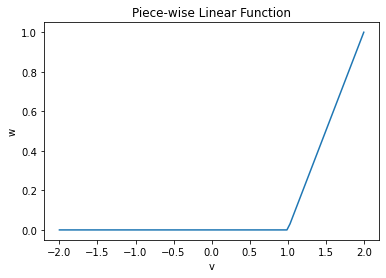

In [22]:
# Part (c)
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
a1 = a2 = 1; b1 = -1; b2 = -2; b3 = 0
A3 = np.array([[1, -1]])

def ReLU(x):  # ReLU function
    return np.maximum(0, x)

def NN(v):  # NN function
    v1 = np.array([ReLU(a1 * v + b1), ReLU(a2 * v + b2)])
    return ReLU(A3 @ v1 + b3)

# Define input values for plotting
v = np.linspace(-2, 2., 100)
w = np.zeros_like(v)
for i, vv in enumerate(v):
    w[i] = NN(vv)
    
plt.plot(v, w)
plt.xlabel('v')
plt.ylabel('w')
plt.title('Piece-wise Linear Function')
plt.show()